In [1]:
from arviz import hdi
import pyabc
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel
from datetime import datetime
import pandas as pd
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix
import matplotlib.pyplot as plt
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix, plot_kde_2d, plot_kde_matrix_for_paper, plot_kde_matrix_for_paper_was

path = '../../results'
output_path = '../../figures'

file_name = 'basic-prior'

history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path,file_name))
history.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2021-12-29 04:47:34.853143,200,inf,1
1,0,2021-12-29 10:54:43.770932,393,0.746575,200
2,1,2021-12-29 11:53:27.456808,4967,0.360622,836
3,2,2021-12-29 13:38:29.537354,9109,0.197467,1059
4,3,2021-12-29 16:37:20.673694,16125,0.145762,1111
5,4,2021-12-29 21:50:47.240188,27629,0.131083,964
6,5,2021-12-30 08:00:52.829615,53803,0.126588,982


In [2]:
def sample_from_kde(file_name, size=50_000, t=None):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, file_name))
    samples, weights = history.get_distribution(m=0, t=None)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(),weights=weights)
    kdesamples = kde.resample(2*size).T
    kdesamples = pd.DataFrame(data=kdesamples,columns=['mutation rate', 'trisomy rate', '2n+1 fitness', '2n+1* fitness', '2n* fitness'])
    kdesamples = kdesamples[(kdesamples['mutation rate']>1e-9) & (kdesamples['mutation rate']<1e-5) &
              (kdesamples['trisomy rate']>1e-6) & (kdesamples['mutation rate']<1e-2)][:size]
    return kdesamples, kde


In [12]:
import warnings
warnings.filterwarnings('ignore')

def plot(samples, kde, lims=False, logscale = False):              
    c1 = 'Mutation rate, $\mu$'
    c2 = 'Aneuploidy rate, $\delta$'
    c3 ='Fitness of 2n+1, $w_{2n+1}$'
    c4 = 'Fitness of 2n+1*, $w_{2n+1*}$'
    c5 = 'Fitness of 2n*, $w_{2n*}$'
    samples = pd.DataFrame(data=samples.values,columns=[c1, c2, c3, c4, c5])

    if logscale is True:
        for c in samples.columns:
            samples[c] = samples[c].apply(lambda x: np.log(x))
            
    size = len(samples)
    weights = np.full(size,1/size)
#     params_hat = scipy.optimize.minimize(lambda x: -kde.logpdf(x) ,samples.median().values)['x']
    params_hat = scipy.optimize.minimize(lambda x: -kde.logpdf(x) if x[0]>1e-9 and x[0]<1e-5 
                                  and x[1]>1e-6 and x[1]<1e-2 else 100
                                  ,samples.median().values)['x']
#     params_hat = samples.median()
    print(params_hat)
    mutl = (10.0**-9,10.0**-5)
    tril = (10.0**-5,10.0**-2)
    limits = {
        c1 : mutl, 
        c2 : tril,
        c3 : (1,1.1),
        c4 : (1,1.1),
        c5 : (1,1.1)}
    
    if logscale is True:
        limits = {i:(np.log(v[0]),np.log(v[1])) for (i,v) in limits.items()}
        
    if lims is True:
        axes = plot_kde_matrix_for_paper_was(
            samples, weights,numx=1000,limits=limits,numy=1000,refval={c:p for c,p in  zip(samples.columns,params_hat)}
        )
    else:
        axes = plot_kde_matrix_for_paper(
            samples, weights,numx=1000,numy=1000,refval={c:p for c,p in  zip(samples.columns,params_hat)},
            refval_color='red'
        )

[2.99235045e-06 1.73198624e-03 1.02214263e+00 1.02472621e+00
 1.02786704e+00]


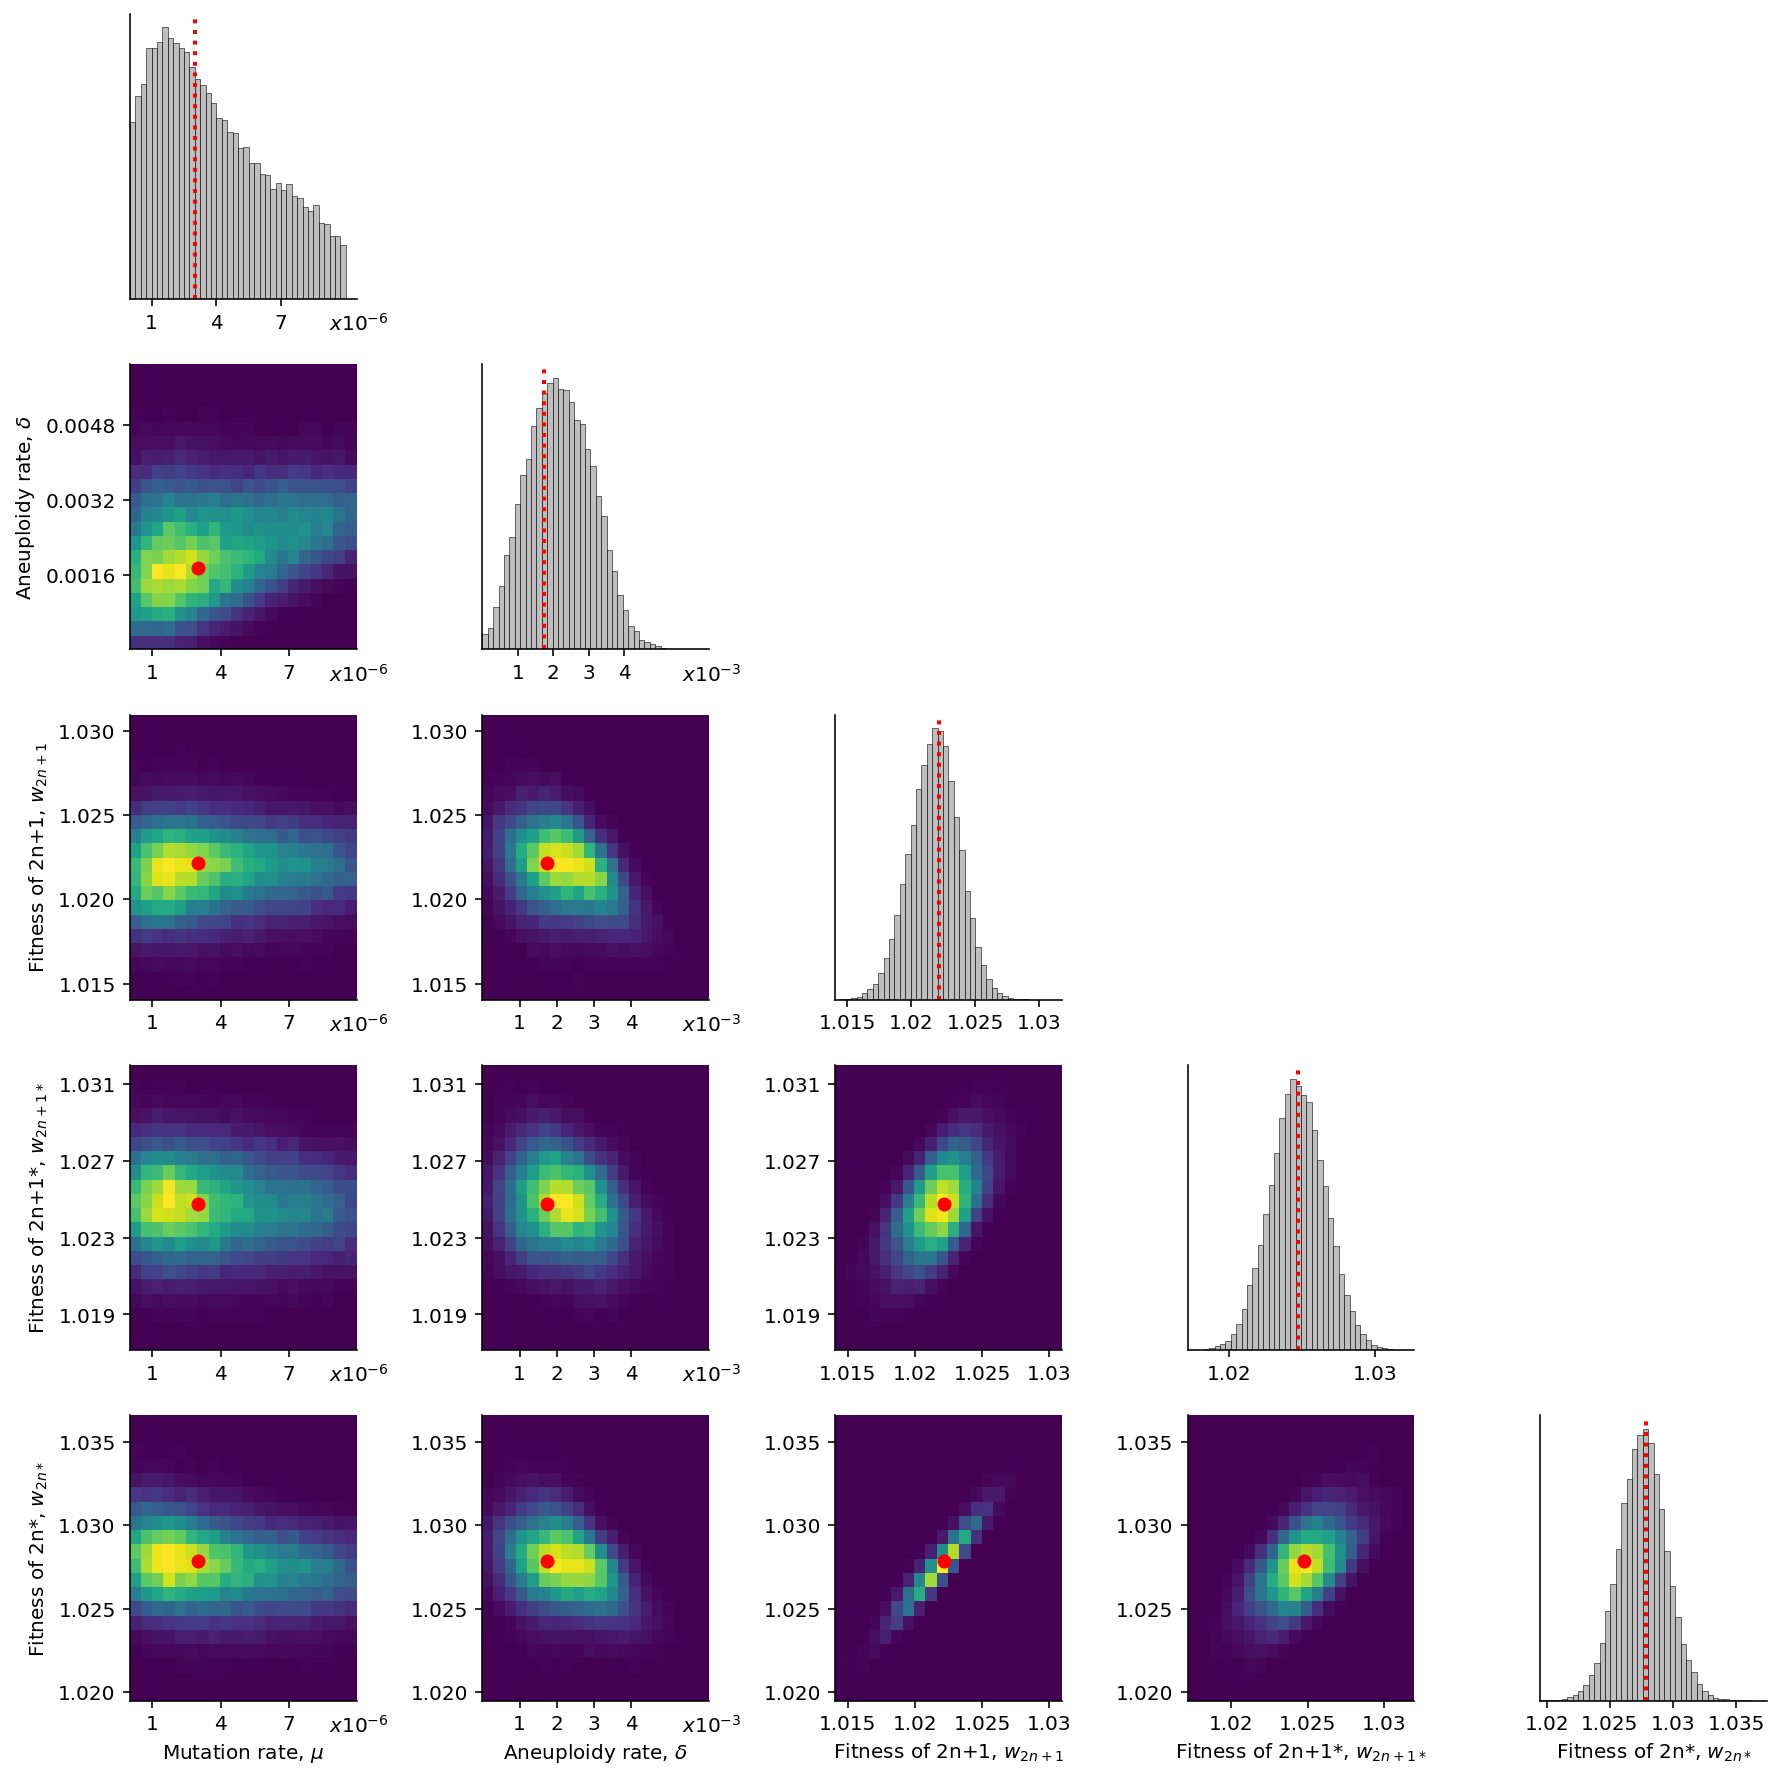

In [9]:
samples, kde = sample_from_kde(file_name, 50_000)
plot(samples, kde, lims=False, logscale=False)
plt.gcf().savefig(f'{output_path}/posterior.pdf', bbox_inches='tight', dpi=400)

[-12.5959211   -6.13500156   0.02164297   0.02443042   0.02724787]


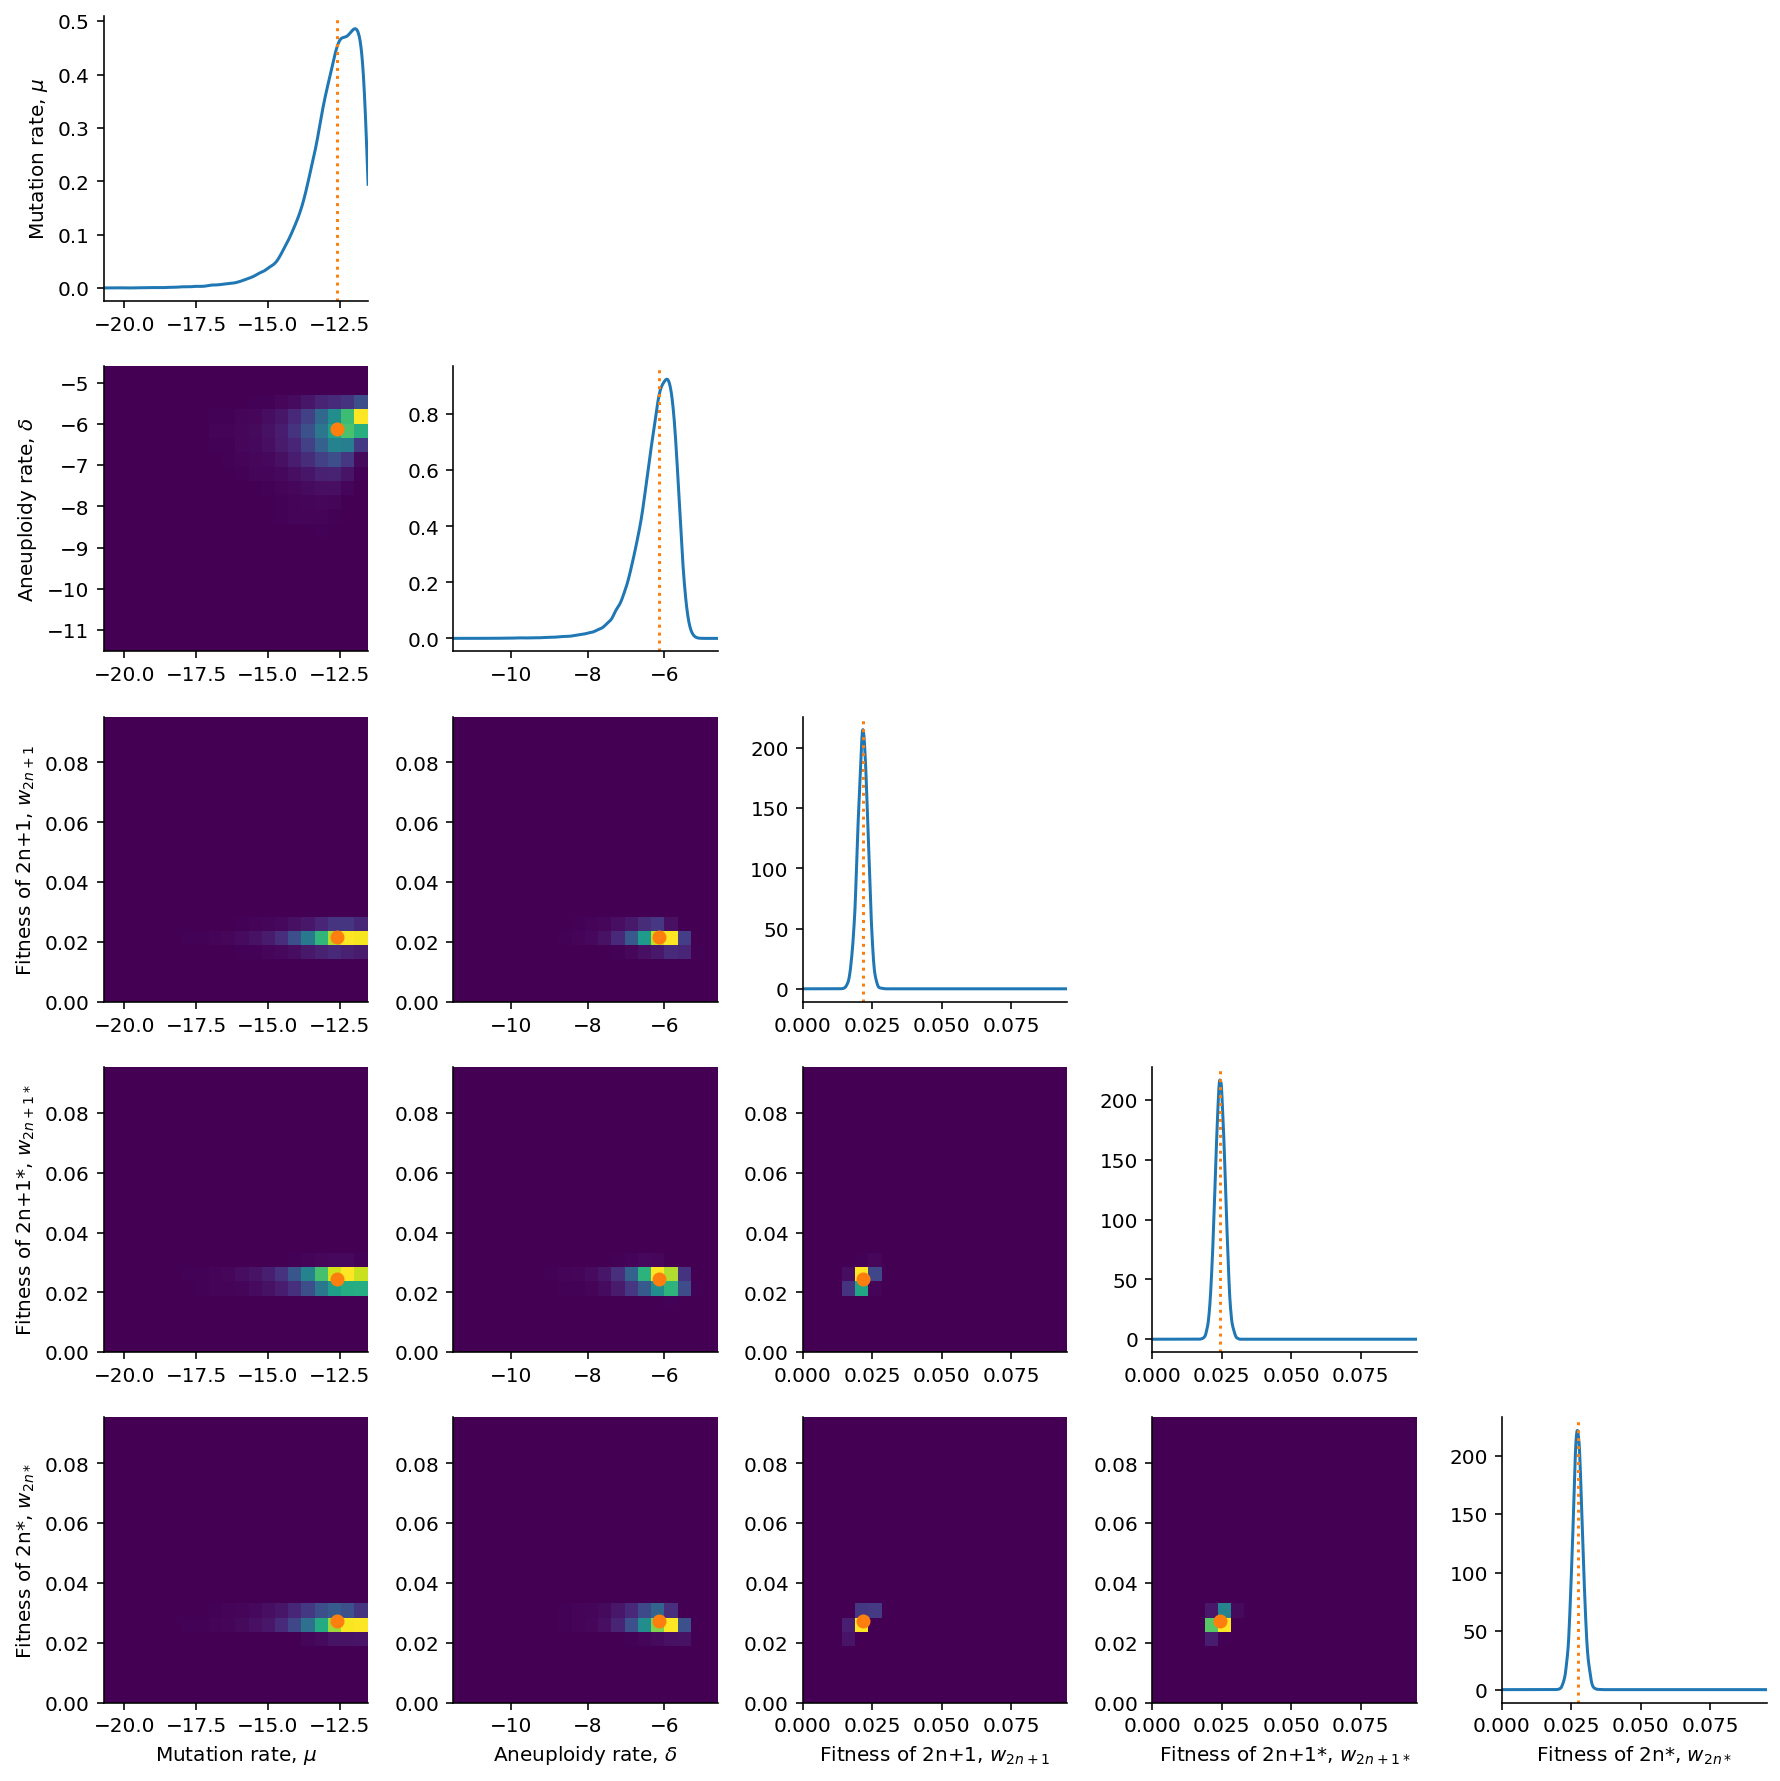

In [16]:
samples, kde = sample_from_kde(file_name, 50_000)
plot(samples, kde, lims=True, logscale=True)

[3.03225036e-06 1.73557290e-03 1.02215633e+00 1.02472238e+00
 1.02787197e+00]


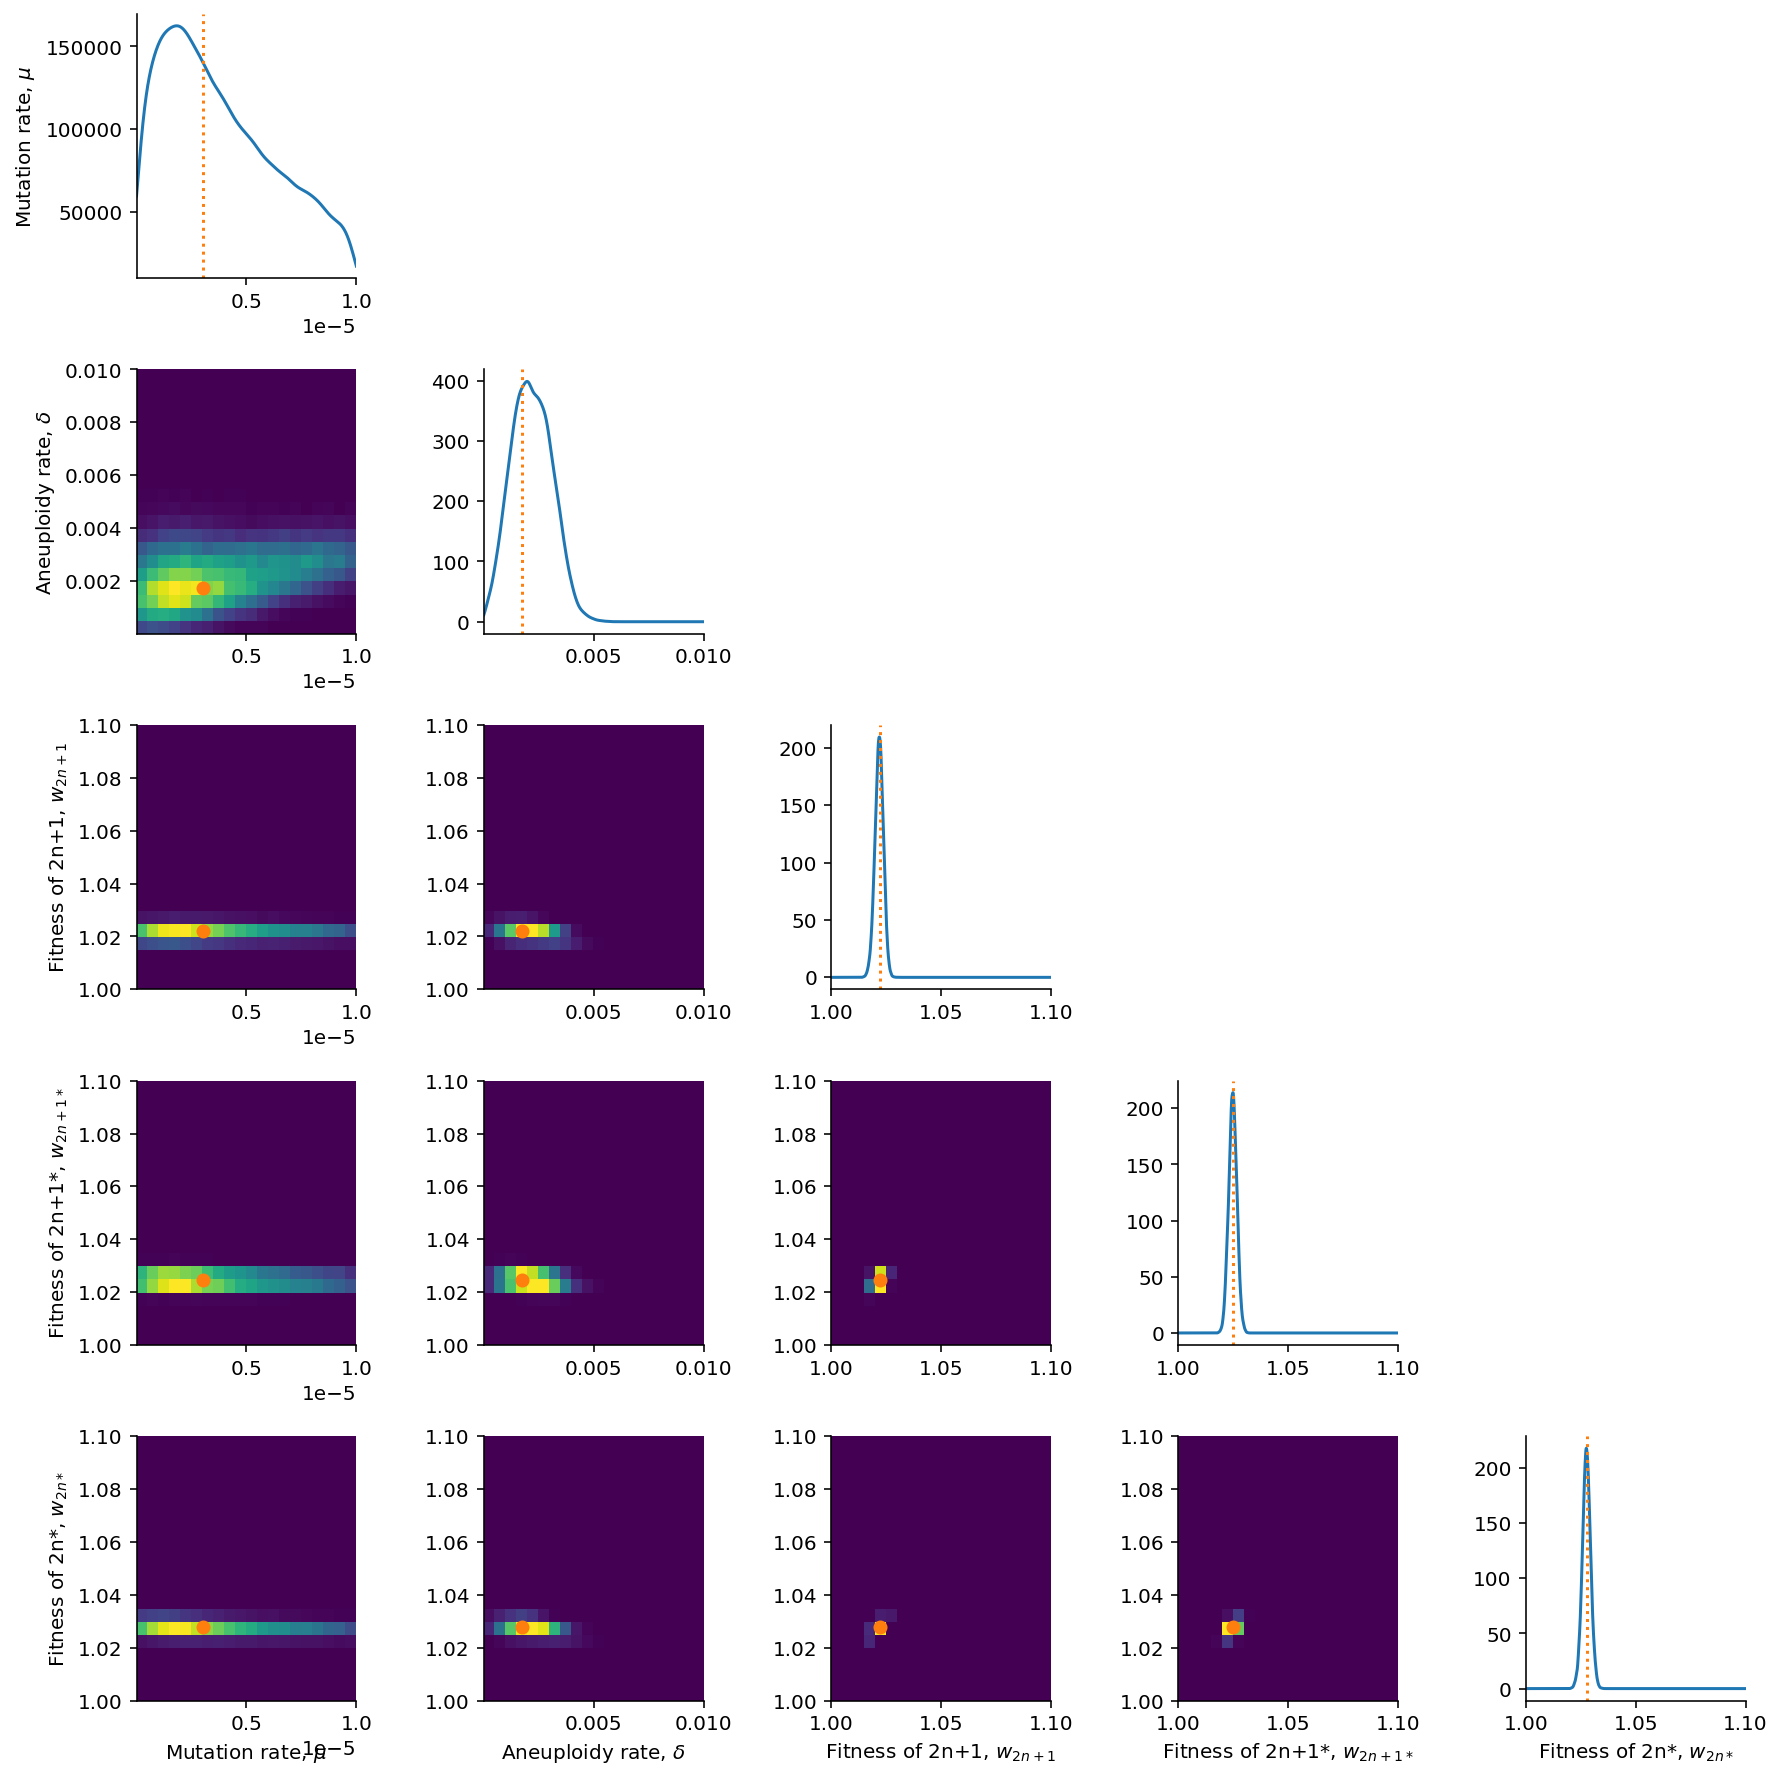

In [18]:
samples, kde = sample_from_kde(file_name, 50_000)
plot(samples, kde, lims=True, logscale=False)